(50000, 32, 32, 3)
(50000,)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3]


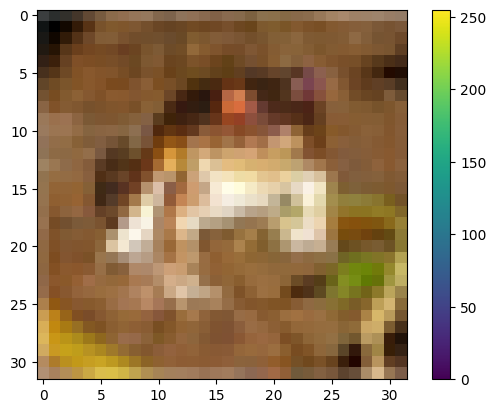

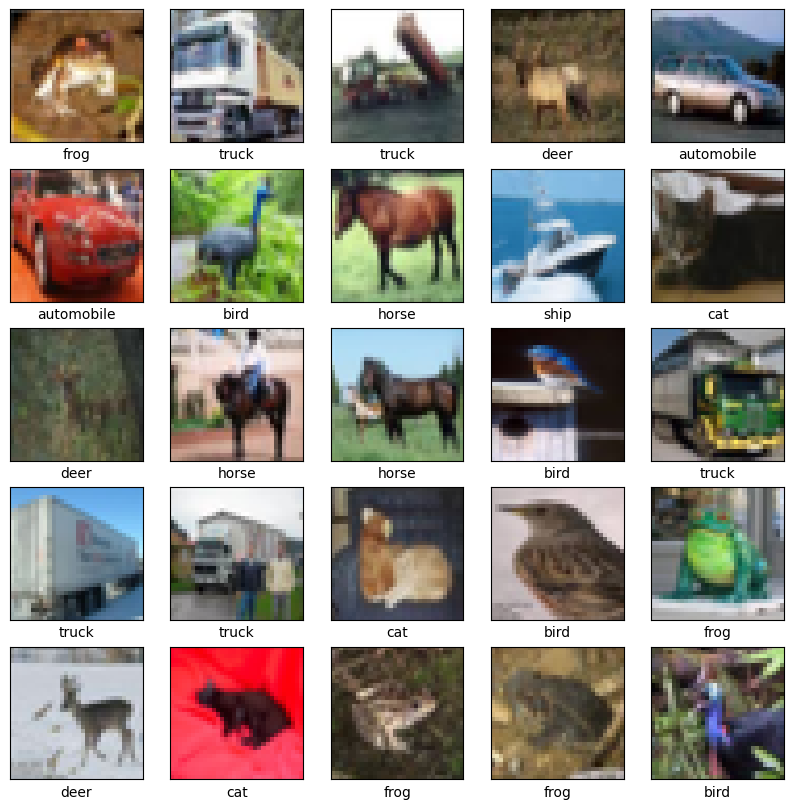

Epoch 1/10:
  Train Loss: 1.4689, Train Accuracy: 0.4677
Epoch 2/10:
  Train Loss: 1.0278, Train Accuracy: 0.6386
Epoch 3/10:
  Train Loss: 0.8213, Train Accuracy: 0.7108
Epoch 4/10:
  Train Loss: 0.6948, Train Accuracy: 0.7553
Epoch 5/10:
  Train Loss: 0.5863, Train Accuracy: 0.7936
Epoch 6/10:
  Train Loss: 0.4762, Train Accuracy: 0.8336
Epoch 7/10:
  Train Loss: 0.3831, Train Accuracy: 0.8649
Epoch 8/10:
  Train Loss: 0.3020, Train Accuracy: 0.8942
Epoch 9/10:
  Train Loss: 0.2308, Train Accuracy: 0.9192
Epoch 10/10:
  Train Loss: 0.1776, Train Accuracy: 0.9373
  Test Loss: 1.2138, Test Accuracy: 0.7236


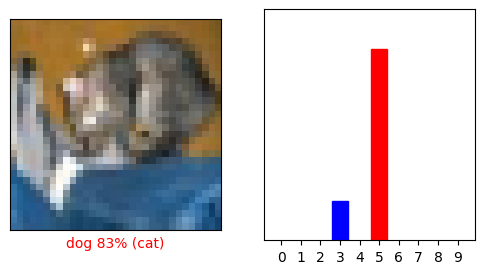

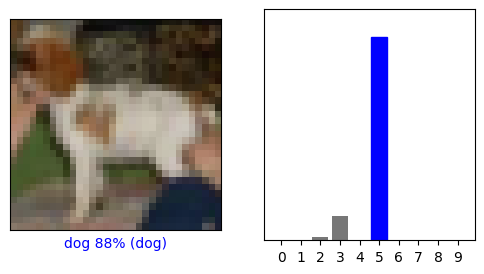

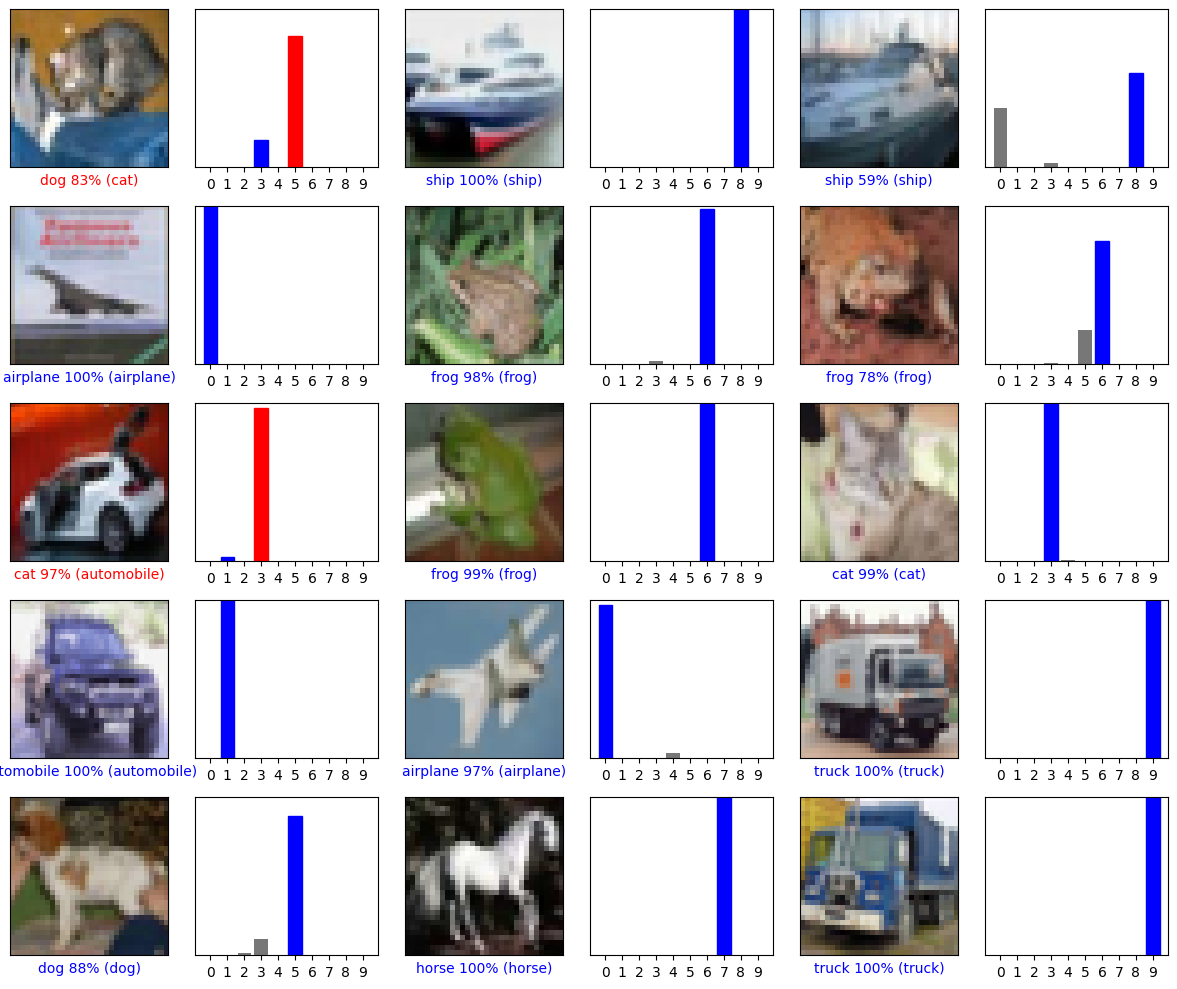

In [2]:
'''
Homework:
Methodology for solving image classification problems.
Train a simple convolutional neural network (CNN) to classify CIFAR images.
'''
# %%
# importing
import torch
import numpy as np
from matplotlib import pyplot as plt
# %%
# load CIFAR-10 data
from torchvision import datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True)
train_images, train_labels = train_dataset.data, train_dataset.targets
test_images, test_labels = test_dataset.data, test_dataset.targets
# %%
# total of 10 image classes, labeled 0-9:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# %%
# the shape of the training set
print(train_images.shape)
# %%
# the shape of the training labels
print(np.array(train_labels).shape)
# %%
# display the training labels 
print(train_labels[:10])
# %%
# visualize the first image in the training set
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()
# %%
# normalize the images to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0
# %%
# display the first 25 training images and their labels
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i]])
plt.show()
# %%
# dataloader
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
train_images_tensor = torch.tensor(train_images, dtype=torch.float32).permute(0,3,1,2)
test_images_tensor = torch.tensor(test_images, dtype=torch.float32).permute(0,3,1,2)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)
train_tensor_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_tensor_dataset = TensorDataset(test_images_tensor, test_labels_tensor)
batch_size = 64
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)
# %%
# build a neural network model
class CIFAR10Model(nn.Module):
    def __init__(self):
        super(CIFAR10Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128*8*8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR10Model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# %%
import torch.optim as optim
from torchmetrics import Accuracy
optimizer = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()
accuracy_metric = Accuracy(task="multiclass", num_classes=10)
# %%
def train_epoch(model, dataloader, optimizer, loss_fn, accuracy_metric, device):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        running_acc += accuracy_metric(preds.cpu(), labels.cpu()) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc
# %%
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, accuracy_metric, device)
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
# %%
def test(model, dataloader, loss_fn, accuracy_metric, device):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            running_acc += accuracy_metric(preds.cpu(), labels.cpu()) * images.size(0)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_acc / len(dataloader.dataset)
    return epoch_loss, epoch_acc
# %%
test_loss, test_acc = test(model, test_loader, loss_fn, accuracy_metric, device)
print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
# %%
# add a softmax layer to convert the outputs into probabilities
probability_model = nn.Sequential(
    model,
    nn.Softmax(dim=1)
)

probability_model.eval()
with torch.no_grad():
    test_input = test_images_tensor.to(device)
    predictions = probability_model(test_input)
    predictions = predictions.cpu().numpy()
# %%
predictions[0]
# %%
predicted_class = np.argmax(predictions[0])
predicted_class
# %%
test_labels_tensor[0].item()
# %%
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                    100*np.max(predictions_array),
                                    class_names[true_label]),
                                    color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
# %%
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels_tensor, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels_tensor)
plt.show()
# %%
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels_tensor, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels_tensor)
plt.show()
# %%
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels_tensor, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels_tensor)
plt.tight_layout()
plt.show()
# %%
